In [1]:
import pandas as pd
import transformers 
import numpy as np
import torch
import torch.nn.functional as F
import datasets

from collections import OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt
import patchworklib as pw

import re
import sys

sys.path.insert(0, '..')

from decompose_gpt2_mixed import GPT2ForSequenceClassificationMixed, GPT2Config
from build_masks import build_masks_with_other, split_pos_neg_contributions
import preprocess_input


<Figure size 100x100 with 0 Axes>

### Load Model

In [2]:
labels = ['awareness', 'change_of_location', 'change_of_state',
       'change_of_possession', 'existed_after', 'existed_before',
       'existed_during', 'instigation', 'sentient', 'volition']

path = "../../combined_SPRL_gpt2"
model = transformers.AutoModelForSequenceClassification.from_pretrained(path)

new_state_dict = OrderedDict()
for key, value in model.state_dict().items():
    # ref : https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
    new_key = key.replace("ln_1.weight", "ln_1.gamma").replace("ln_1.bias", "ln_1.beta")
    new_key = new_key.replace("ln_2.weight", "ln_2.gamma").replace("ln_2.bias", "ln_2.beta")
    new_key = new_key.replace("ln_f.weight", "ln_f.gamma").replace("ln_f.bias", "ln_f.beta")
    new_state_dict[new_key] = value


In [3]:
mixed_model = GPT2ForSequenceClassificationMixed(
    config= GPT2Config.from_dict(model.config.to_dict()),
    state_dict=new_state_dict,
    segment_layer=0,
    debug=False, 
    num_labels=len(labels) * 3
    )

tokenizer = transformers.AutoTokenizer.from_pretrained(path + "/tokenizer")


### Load Data

In [4]:
roles_wide = pd.read_csv("../../../dataV2/combined_V1_V2.csv", na_filter=False)
roles_wide.drop("Unnamed: 0", inplace=True, axis=1)

roles_wide.rename({"Sentence": "sentence", "Arg.Phrase": "arg"}, axis=1, inplace=True)

properties_list = ['awareness', 'change_of_location', 'change_of_state',
       'change_of_possession', 'existed_after', 'existed_before',
       'existed_during', 'instigation', 'sentient', 'volition']

print(roles_wide.shape)
roles_wide["combined_labels"] = roles_wide["combined_labels"].apply(lambda x: eval(x))
roles_wide.head()


(28820, 16)


,Sentence.ID,Roleset,Gram.Func,sentence,Predicate,Split,arg,Arg.Stripped,arg_idx,verb_idx,structure,decomp_version,Pred.Lemma,modified_sentence,Arg.Parse,combined_labels
0,0003_21,impose.01,nsubj,"In July , a gradual ban was imposed by the Env...",was imposed by,test,a gradual ban,a ban,"(3, 6)","(6, 9)",passive_full,V1,impose,1,,"[1.0, 1.0, 3.0, 1.0, 5.0, 1.0, 5.0, 1.0, 1.0, ..."
1,0003_21,impose.01,dobj,"In July , a gradual ban was imposed by the Env...",was imposed by,train,the Environmental Protection Agency,the Environmental Protection Agency,"(9, 13)","(6, 9)",passive_full,V1,impose,1,,"[5.0, 1.0, 3.0, 1.0, 5.0, 5.0, 5.0, 5.0, 1.0, ..."
2,0003_29,have.03,nsubj,No bearing on our work force today is had by it .,is had by,train,No bearing on our work force today,no bearing,"(0, 7)","(7, 10)",passive_full,V1,have,1,,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,0003_29,have.03,dobj,No bearing on our work force today is had by it .,is had by,test,it,It,"(10, 11)","(7, 10)",passive_full,V1,have,1,,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 3.0, 2.0, ..."
4,0003_9,lead.02,nsubj,A team of researchers from the National Cancer...,was led by,train,A team of researchers from the National Cancer...,a team,"(0, 19)","(19, 22)",passive_full,V1,lead,1,,"[5.0, 3.0, 3.0, 1.0, 3.0, 3.0, 5.0, 3.0, 1.0, ..."


In [5]:
eval_df = roles_wide.loc[
    (roles_wide["decomp_version"] == "V2") & \
    (roles_wide["Split"] == "test")
    # (roles_wide["modified_sentence"] == 0)
    ][["Pred.Lemma", "Gram.Func", "structure", "sentence", "Predicate", "arg_idx", "verb_idx", "arg", "Arg.Stripped"]].drop_duplicates().reset_index()

print(eval_df.shape)
eval_df


(639, 10)


,index,Pred.Lemma,Gram.Func,structure,sentence,Predicate,arg_idx,verb_idx,arg,Arg.Stripped
0,14299,raise,nsubj,active_full,A girl raises her hand .,raises,"(0, 2)","(2, 3)",A girl,A girl
1,14301,raise,dobj,active_full,A girl raises her hand .,raises,"(3, 5)","(2, 3)",her hand,the hand
2,14303,be,nsubj,active_full,""" I 'm afraid not , "" explains Winston , "" tha...",is,"(11, 12)","(12, 13)",that,that
3,14305,say,nsubj,active_full,"In a timid voice , he says : "" If an airplane ...",says,"(5, 6)","(6, 7)",he,he
4,14307,beam,nsubj,active_full,""" Wonderful ! "" Winston beams .",beams,"(4, 5)","(5, 6)",Winston,Winston
...,...,...,...,...,...,...,...,...,...,...
634,21902,enjoy,nsubj,passive_full,The animations were enjoyed by me and wanted t...,were enjoyed by,"(0, 2)","(2, 5)",The animations,the animations
635,21904,have,nsubj,passive_full,A Full Color Catalog and Wholesale Price List ...,is had by,"(0, 14)","(14, 17)",A Full Color Catalog and Wholesale Price List ...,a Color Catalog and Price List
636,21906,have,dobj,passive_full,A Full Color Catalog and Wholesale Price List ...,is had by,"(17, 18)","(14, 17)",us,We
637,21908,accecpt,nsubj,passive_full,"Visa , MasterCard , Amex , Dinner s Club / Car...",are accecpted by,"(0, 19)","(19, 22)","Visa , MasterCard , Amex , Dinner s Club / Car...",Visa MasterCard Amex the Club / Carte Blanche ...


### Make Contribution Masks and Process Sentences

In [6]:
dataset, eval_df, lengths = build_masks_with_other(eval_df, tokenizer).values()

print(max(lengths))
eval_df.head()


!!!!!!! her hand!

arg:  her hand
stripped arg:  the hand
arg reconstructed (no mod):  hand
mod reconstructed:  her
A girl!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! SPACE.com!
!!!!!!!!!!!!!!!!!!!!!!!!!!!! Kistler!!!!!!!!!

arg:  Our plans
stripped arg:  the plans
arg reconstructed (no mod):  plans
mod reconstructed:  Our

arg:  Walter Kistler, LTS co-founder and Chairman
stripped arg:  Kistler
arg reconstructed (no mod):  Kistler,
mod reconstructed:  Walter LTS co-founder and Chairman

arg:  the letter, signed by NASA Administrator Mike Griffin and the Pentagon's top space official, ex-astronaut Ron Sega
stripped arg:  the letter signed
arg reconstructed (no mod):  the letter, signed
mod reconstructed:  by NASA Administrator Mike Griffin and the Pentagon's top space official, ex-astronaut Ron Sega
The Sunni AMS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

arg:  The Sunni AMS
stripped arg:  The AMS
arg reconstructed (no mod):  The AMS
mod reconstructed:  Sunni
!!!!!!!!! Iraqis!!!!!!!!!!!!!!!

,index,sentence,structure,gram,contribution,mask
0,14299,<a>A girl<a><p> raises<p> her hand.,active_full,nsubj,arg_nomod_mask,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]"
1,14301,A girl<p> raises<p><a> her hand<a>.,active_full,dobj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"


In [7]:
max_length = 128

def tokenize_and_mask(t):
    encoded = tokenizer(t["sentence"], padding="max_length", truncation=True,
                        max_length=max_length, return_tensors="pt")
    beta_mask = np.pad(t["mask"], (0, max_length - len(t["mask"])%max_length), 'constant')
    beta_mask = torch.Tensor(beta_mask).to(int)
    beta_mask = torch.stack([beta_mask, 1 - beta_mask])
    encoded["beta_mask"] = beta_mask
    return encoded

test_set = datasets.Dataset.from_pandas(eval_df)
test_set = test_set.map(tokenize_and_mask)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/2556 [00:00<?, ? examples/s]

In [8]:
# for layer in range(1, 24):
#     gen = test_set.iter(batch_size=8)
#     mixed_model.segment_layer = layer

#     with torch.no_grad():
#         for i, batch in enumerate(gen):
#             beta_mask = torch.Tensor(batch["beta_mask"]).to(torch.long)
#             attention_mask = torch.Tensor(batch["attention_mask"]).to(torch.long).squeeze(1)
#             input_ids = torch.Tensor(batch["input_ids"]).to(torch.long).squeeze(1)

#             l = mixed_model(input_ids=input_ids,
#                             attention_mask=attention_mask,
#                             beta_mask=beta_mask,
#                             num_contributions=2)["logits"].numpy()

#             np.save(f"layer-gcd_logits/gpt2/layer_{layer}/batch_{i}_logits.npy", l)
#             if i % 10 == 0:
#                 print(layer, i)


### Analyze Contributions


In [9]:
layer_binary_logits = {}
# for layer in [0, 23]:
for layer in range(24):
    logits = []
    for i in range(320):
    # for i in range(640):
        a = np.load(f"layer-gcd_logits/gpt2/layer_{layer}/batch_{i}_logits.npy")
        # a = np.load(f"layer-gcd_logits/roberta-dropout=0.1/layer_{layer}/batch_{i}_logits.npy")
        logits.append(a)

    logits = np.concatenate(logits, axis=1).reshape(3, -1, 3, 10)
    binary_logits = preprocess_input.split_pos_neg_contributions(logits)
    layer_binary_logits[layer] = binary_logits
    # layer_binary_logits[layer] = logits

logits.shape


(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)
(3, 2556, 2, 10)


(3, 2556, 3, 10)

In [16]:
contributions_df = eval_df.copy(deep=True)

# for layer in [0, 23]:
for layer in range(24):
    binary_logits = layer_binary_logits[layer]
    contributions_df[layer] = (binary_logits[0] / (binary_logits[:2].sum(0).sum(1, keepdims=True) + 1e-10)).tolist()
    # contributions_df[layer] = binary_logits[0].tolist()

contributions_df["span_length"] = contributions_df["mask"].apply(lambda x: x.astype(int).sum())
# contributions_df.dropna(subset="span_length", inplace=True)

# for layer in [0, 23]:
for layer in range(24):
    contributions_df[layer] = contributions_df.apply(
        lambda x: np.array(x[layer])/(x["span_length"] + 1e-10),
        axis=1,
    )

contributions_df = contributions_df.melt(
    id_vars=["sentence", "index", "contribution", "gram", "structure"],
    # value_vars=[0, 23],
    value_vars=range(24),
    value_name="beta_contribution", 
    var_name="segment_layer")

print(contributions_df.shape)
contributions_df.head()   


(61344, 7)


,sentence,index,contribution,gram,structure,segment_layer,beta_contribution
0,<a>A girl<a><p> raises<p> her hand.,14299,arg_nomod_mask,nsubj,active_full,0,"[[-0.0, -0.0, -0.0, 0.048012718816420975, 0.07..."
1,A girl<p> raises<p><a> her hand<a>.,14301,arg_nomod_mask,dobj,active_full,0,"[[-0.0, -0.0, 0.11282475999815249, -0.0, -0.0,..."
2,"""I 'm afraid not"", explains Winston, ""<a> that...",14303,arg_nomod_mask,nsubj,active_full,0,"[[0.21445755972050268, 0.07924393080538623, -0..."
3,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",14305,arg_nomod_mask,nsubj,active_full,0,"[[-0.0, -0.0, -0.0, 0.12256765215388116, -0.0,..."
4,"""Wonderful!""<a> Winston<a><p> beams<p>.",14307,arg_nomod_mask,nsubj,active_full,0,"[[-0.0, -0.0, 0.08358995160540064, 0.253334636..."


In [17]:
contributions_df[labels] = contributions_df['beta_contribution'].apply(lambda x: pd.Series(np.array(x).T.tolist()))

contributions_df = contributions_df.melt(
    id_vars=["sentence", "index", "contribution", "gram", "structure", "segment_layer"],
    value_vars=labels, value_name="logits", var_name="property")
contributions_df[["negative", "positive"]] = contributions_df['logits'].apply(lambda x: pd.Series(np.array(x).T.tolist()))

spans = {
    "arg_nomod": "argument",
    "arg_mod": "modifier",
    "pred": "predicate",
    "other_args": "other"
}
contributions_df["span"] = contributions_df["contribution"].apply(
    lambda x: spans["_".join(x.split("_")[:-1])])

contributions_df = contributions_df.melt(
    id_vars=[ "index", "sentence","span", "property", "gram", "structure",
             "segment_layer"],
    value_vars=["negative", "positive"],
    var_name="class", value_name="per_token_contribution")

contributions_df["structure"] = contributions_df["structure"].apply(
    lambda x: "_".join(x.split("_")[:-1]))
contributions_df["proto-role property"] = contributions_df["property"].apply(
    lambda x: "proto-patient" if "change" in x else "proto-agent"
)
contributions_df["position"] = contributions_df.apply(
    lambda x: "agent" if (
            x["gram"] == "nsubj" and x["structure"] == "active"
        ) or (
            x["gram"] == "dobj" and x["structure"] == "passive")
        else "patient",
    axis=1
)

contributions_df.head()


,index,sentence,span,property,gram,structure,segment_layer,class,per_token_contribution,proto-role property,position
0,14299,<a>A girl<a><p> raises<p> her hand.,argument,awareness,nsubj,active,0,negative,-0.000000,proto-agent,agent
1,14301,A girl<p> raises<p><a> her hand<a>.,argument,awareness,dobj,active,0,negative,-0.000000,proto-agent,patient
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",argument,awareness,nsubj,active,0,negative,0.214458,proto-agent,agent
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",argument,awareness,nsubj,active,0,negative,-0.000000,proto-agent,agent
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",argument,awareness,nsubj,active,0,negative,-0.000000,proto-agent,agent


In [18]:
# scale each by contribution over total (including both)

contributions_df["total"] = contributions_df.groupby(
    ["sentence", "gram", "property", "structure", "segment_layer",
    #  "class",
     "proto-role property", "position"]
    )["per_token_contribution"].transform(np.sum).replace(0, np.nan)
contributions_df.dropna(subset="total", inplace=True)

contributions_df["% contribution"] = contributions_df["per_token_contribution"] / contributions_df["total"] * 100

contributions_df.head()


,index,sentence,span,property,gram,structure,segment_layer,class,per_token_contribution,proto-role property,position,total,% contribution
0,14299,<a>A girl<a><p> raises<p> her hand.,argument,awareness,nsubj,active,0,negative,-0.000000,proto-agent,agent,0.383344,-0.000000
1,14301,A girl<p> raises<p><a> her hand<a>.,argument,awareness,dobj,active,0,negative,-0.000000,proto-agent,patient,1.349049,-0.000000
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",argument,awareness,nsubj,active,0,negative,0.214458,proto-agent,agent,0.427569,50.157376
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",argument,awareness,nsubj,active,0,negative,-0.000000,proto-agent,agent,0.472779,-0.000000
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",argument,awareness,nsubj,active,0,negative,-0.000000,proto-agent,agent,0.570211,-0.000000


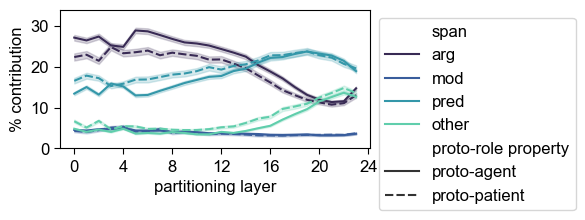

In [24]:
contributions_df["PRP"] = contributions_df["proto-role property"]
# contributions_df["span"] = contributions_df["span"].map({
#     "argument": "arg",
#     "modifier": "mod",
#     "predicate": "pred",
#     "other": "other"
# })

plt.figure(figsize=(4, 1.8))
ax = sns.lineplot(
    contributions_df,
    y="% contribution",
    x="segment_layer",
    hue="span",
    legend=True,
    style="proto-role property",
    palette="mako"
)
ax.set(ylim=(0, 34), xticks=np.arange(0, 25, 4))
ax.set_xlabel("partitioning layer")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
